In [1]:
using Printf
using Plots

In [2]:
struct IDX_NML
    D::Int
    E::Int
    ET::Int
    S::Int
    PX::Int
    PY::Int
    PZ::Int
    BX::Int
    BY::Int
    BZ::Int
    QR::Int
    TT::Int
    PHI::Int
    P1::Int
    P2::Int
    P3::Int
    B1::Int
    B2::Int
    B3::Int
    EX::Int
    EY::Int
    EZ::Int
    JX::Int
    JY::Int
    JZ::Int
    RPHI::Int
end

struct IO_NML
    FORMAT::Int
    NTOTAL::Int
    OUT_TIME::Float64
    GUARD_ZONES::Bool
    TIME_DERIVS::Int
    METHOD::String
    NML_VERSION::Int
    DO_GENERIC::Bool
end

struct SNAPSHOT_NML
    IOFORMAT::Int
    IOUT::Int
    TIME::Float64
    NTOTAL::Int
    BOX::Vector{Float64}
    LI::Vector{Int}
    UI::Vector{Int}
    NG::Vector{Int}
    GN::Vector{Int}
    N::Vector{Int}
    NV::Int
    MV::Int
    NT::Int
    GAMMA::Float64
    EOS_NAME::String
    OPACITY::String
    PERIODIC::Vector{Bool}
    GUARD_ZONES::Bool
    TIME_DERIVS::Int
    NO_MANS_LAND::Bool
    OMP_NTHREADS::Int
    MPI_SIZE::Int
    MESH_TYPE::Int
    MPI_DIMS::Vector{Int}
    REFINE_RATIO::Int
    ORIGIN::Vector{Float64}
end


struct NBOR_NML
    PARENT_ID :: Int
    NBOR_IDS :: Vector{Int}
end


struct Patch_NML
    ID::Int
    POSITION::Vector{Float64} 
    SIZE::Vector{Float64} 
    LEVEL::Int
    DTIME::Float64
    ISTEP::Int
    DS::Vector{Float64} 
    NCELL::Vector{Int}
    N::Vector{Int}
    NW::Int
    VELOCITY::Vector{Float64} 
    QUALITY::Float64
    MESH_TYPE::Int
    KIND::String
    ETYPE::String
    RECORD::Int
    RANK::Int
    IPOS::Vector{Int} 
    COST::Float64
    CENTRE_NAT::Vector{Float64} 
    LLC_NAT::Vector{Float64}
    EROT1::Vector{Float64}
    EROT2::Vector{Float64}
    EROT3::Vector{Float64}
    NBOR_NML::NBOR_NML # list of neighbors
    DATA_POS::Int # position in the data file
    DATA_FILE::String # data file
end


struct Snapshot_metadata
    IO :: IO_NML
    SNAPSHOT:: SNAPSHOT_NML
    IDX :: IDX_NML
    PATCHES :: Vector{Patch_NML}
    n_patches :: Int
    folder :: String
end 

In [3]:
function parse_array(value::String)
    elements = split(value, ",")
    parsed_elements = String[]
    for element in elements
        element = strip(element)
        if occursin(r"\*", element)
            parts = split(element, "*")
            count = parse(Int, strip(parts[1]))
            repeated_value = strip(parts[2])
            append!(parsed_elements, fill(repeated_value, count))
        else
            push!(parsed_elements, element)
        end
    end
    return join(parsed_elements, ",")[1:end-1]
end


function parse_value(value::String, type::DataType)
    if type == Int
        return parse(Int, strip(value, ','))
    elseif type == Float64
        return parse(Float64, strip(value, ','))
    elseif type == Bool
        return strip(value, ',') == "T"
    elseif type == String
        return strip(strip(value, ','), ''')
    elseif type == Vector{Int}
        array_str = parse_array(value)
        return [parse(Int, val) for val in split(array_str, ',')]
    elseif type == Vector{Float64}
        array_str = parse_array(value)
        return [parse(Float64, val) for val in split(array_str, ',')]
    elseif type == Vector{Bool}
        array_str = parse_array(value)
        return [val == "T" for val in split(array_str, ',')]
    else
        error("Unsupported data type: $type")
    end
end

parse_value (generic function with 1 method)

In [4]:
function int_to_fixed_length_string(number::Int, length::Int)
    number_str = string(number)
    return lpad(number_str, length, '0')
end

int_to_fixed_length_string (generic function with 1 method)

In [5]:
function parse_name_content_NML(content::String)
    matches = eachmatch(r"(?s)&.*?/", content)
    sections  = [match.match[2:end-3] for match in matches]

    params_list = []

    for (i, section) in enumerate(sections)
        lines = split(section, "\n")
        name = strip(lines[1])[1:end-4]
        content = join(lines[2:end], "\n")
        push!(params_list, (name, content))
    end

    return params_list
end
#--------------------------------------------------------------------------------------------------------

#----------- Creates a dictionary with parameters and values for a single section of an nml file ------
function parse_params(params::String)
    lines = split(params, "\n")
    param_dict = Dict{String, String}()
    current_key = ""
    for line in lines
        if contains(line, "=")
            key_value = split(line, "=")
            key = strip(key_value[1])
            value = replace(strip(key_value[2]), " " => "")
            param_dict[key] = value
            current_key = key
        elseif current_key != ""
            value = replace(strip(line), " " => "")
            param_dict[current_key] *= value
        end
    end
    return param_dict
end
#--------------------------------------------------------------------------------------------------------

function parse_SNAPSHOT_NML(params :: String)
    dict = parse_params(params)
    Snapshot_params = SNAPSHOT_NML(
        parse_value(dict["IOFORMAT"], Int),
        parse_value(dict["IOUT"], Int),
        parse_value(dict["TIME"], Float64),
        parse_value(dict["NTOTAL"], Int),
        parse_value(dict["BOX"], Vector{Float64}),
        parse_value(dict["LI"], Vector{Int}),
        parse_value(dict["UI"], Vector{Int}),
        parse_value(dict["NG"], Vector{Int}),
        parse_value(dict["GN"], Vector{Int}),
        parse_value(dict["N"], Vector{Int}),
        parse_value(dict["NV"], Int),
        parse_value(dict["MV"], Int),
        parse_value(dict["NT"], Int),
        parse_value(dict["GAMMA"], Float64),
        parse_value(dict["EOS_NAME"], String),
        parse_value(dict["OPACITY"], String),
        parse_value(dict["PERIODIC"], Vector{Bool}),
        parse_value(dict["GUARD_ZONES"], Bool),
        parse_value(dict["TIME_DERIVS"], Int),
        parse_value(dict["NO_MANS_LAND"], Bool),
        parse_value(dict["OMP_NTHREADS"], Int),
        parse_value(dict["MPI_SIZE"], Int),
        parse_value(dict["MESH_TYPE"], Int),
        parse_value(dict["MPI_DIMS"], Vector{Int}),
        parse_value(dict["REFINE_RATIO"], Int),
        parse_value(dict["ORIGIN"], Vector{Float64})
    )
    return Snapshot_params
end


function parse_IO_NML(params :: String)
    dict = parse_params(params)
    IO_params = IO_NML(
      parse_value(dict["FORMAT"], Int) ,
      parse_value(dict["NTOTAL"], Int) ,
      parse_value(dict["OUT_TIME"], Float64) ,
      parse_value(dict["GUARD_ZONES"], Bool) ,
      parse_value(dict["TIME_DERIVS"], Int) ,
      parse_value(dict["METHOD"], String) ,
      parse_value(dict["NML_VERSION"], Int) ,
      parse_value(dict["DO_GENERIC"], Bool) 
        )
    return IO_params
end

function parse_IDX_NML(params :: String)
    dict = parse_params(params)
    IDX_params = IDX_NML(
        parse_value(dict["D"], Int),
        parse_value(dict["E"], Int),
        parse_value(dict["ET"], Int),
        parse_value(dict["S"], Int),
        parse_value(dict["PX"], Int),
        parse_value(dict["PY"], Int),
        parse_value(dict["PZ"], Int),
        parse_value(dict["BX"], Int),
        parse_value(dict["BY"], Int),
        parse_value(dict["BZ"], Int),
        parse_value(dict["QR"], Int),
        parse_value(dict["TT"], Int),
        parse_value(dict["PHI"], Int),
        parse_value(dict["P1"], Int),
        parse_value(dict["P2"], Int),
        parse_value(dict["P3"], Int),
        parse_value(dict["B1"], Int),
        parse_value(dict["B2"], Int),
        parse_value(dict["B3"], Int),
        parse_value(dict["EX"], Int),
        parse_value(dict["EY"], Int),
        parse_value(dict["EZ"], Int),
        parse_value(dict["JX"], Int),
        parse_value(dict["JY"], Int),
        parse_value(dict["JZ"], Int),
        parse_value(dict["RPHI"], Int)
    )

end

function parse_NBOR_NML(params :: String)
    dict = parse_params(params)

    NBOR_params = NBOR_NML(
        parse_value(dict["PARENT_ID"], Int),
        parse_value(dict["NBOR_IDS"], Vector{Int})
    )

    return NBOR_params
end

function parse_PATCH_NML(params :: String, NBOR_params :: NBOR_NML, data_pos :: Int, data_file :: String)
    dict = parse_params(params)

    PATCH_params = Patch_NML(
        parse_value(dict["ID"], Int),
        parse_value(dict["POSITION"], Vector{Float64}),
        parse_value(dict["SIZE"], Vector{Float64}),
        parse_value(dict["LEVEL"], Int),
        parse_value(dict["DTIME"], Float64),
        parse_value(dict["ISTEP"], Int),
        parse_value(dict["DS"], Vector{Float64}),
        parse_value(dict["NCELL"], Vector{Int}),
        parse_value(dict["N"], Vector{Int}),
        parse_value(dict["NW"], Int),
        parse_value(dict["VELOCITY"], Vector{Float64}),
        parse_value(dict["QUALITY"], Float64),
        parse_value(dict["MESH_TYPE"], Int),
        parse_value(dict["KIND"], String),
        parse_value(dict["ETYPE"], String),
        parse_value(dict["RECORD"], Int),
        parse_value(dict["RANK"], Int),
        parse_value(dict["IPOS"], Vector{Int}),
        parse_value(dict["COST"], Float64),
        parse_value(dict["CENTRE_NAT"], Vector{Float64}),
        parse_value(dict["LLC_NAT"], Vector{Float64}),
        parse_value(dict["EROT1"], Vector{Float64}),
        parse_value(dict["EROT2"], Vector{Float64}),
        parse_value(dict["EROT3"], Vector{Float64}),
        NBOR_params,
        data_pos,
        data_file
    )

    return PATCH_params
end 


function parse_snapshot_nml(file_path::String)
    content = read(file_path, String)

    params_list = parse_name_content_NML(content)


    IO_content = [content for (name,content) in params_list if name == "IO"][1]
    IDX_content = [content for (name,content) in params_list if name == "IDX"][1]
    SNAPSHOT_content = [content for (name,content) in params_list if name == "SNAPSHOT"][1]


    IO_params = parse_IO_NML(IO_content)
    IDX_params = parse_IDX_NML(IDX_content)
    Snapshot_params = parse_SNAPSHOT_NML(SNAPSHOT_content)

    return IO_params, IDX_params, Snapshot_params
end 

parse_snapshot_nml (generic function with 1 method)

In [7]:
function parse_patch(patch_param :: String, nbor_param :: String, data_pos :: Int, data_file :: String)
    NBOR_params = parse_NBOR_NML(nbor_param)
    Patch_params = parse_PATCH_NML(patch_param, NBOR_params, data_pos, data_file)

    return Patch_params
end 

function parse_patches_nml(file_path::String, data_file::String)
    content = read(file_path, String)
    params_list = parse_name_content_NML(content)

    params_list = params_list[2:end] # remove the IDX_NML section


    n_sections = size(params_list)[1]
    n_patches = Int(n_sections/2)
    patches_params = []

    data_pos = 1
    for i in 1:2:n_sections
        patch_param = params_list[i][2]
        nbor_param = params_list[i+1][2]

        PATCH_params = parse_patch(params_list[i][2], params_list[i+1][2], data_pos, data_file)
        push!(patches_params, PATCH_params)
        data_pos = data_pos + 1
    end 

    return patches_params, n_patches
end

function read_snapshot(folder)
    snapshot_nml_file = folder * "snapshot.nml"
    IO_params, IDX_params, Snapshot_params = parse_snapshot_nml(snapshot_nml_file)


    patches_params = []
    n_patches = 0 

    for MPI_rank in 0:Snapshot_params.MPI_SIZE-1
        patches_nml_file = folder * "rank_" * int_to_fixed_length_string(MPI_rank, 5) * "_patches.nml"
        data_file = folder * "snapshot_" * int_to_fixed_length_string(MPI_rank, 5) * ".dat"

        patches_params_rank, n_patches_rank = parse_patches_nml(patches_nml_file,data_file)
        patches_params = vcat(patches_params, patches_params_rank)
        n_patches = n_patches + n_patches_rank
    end 


    Snapshot_meta = Snapshot_metadata(IO_params, Snapshot_params, IDX_params, patches_params, n_patches, folder)

    return Snapshot_meta
end 


read_snapshot (generic function with 1 method)

In [8]:
data_folder = "example_data"
snapshot_folder = data_folder * "/00050/"

Snapshot_meta = read_snapshot(snapshot_folder);

In [9]:
function load_patch_data(Snapshot_meta, patch_ID)

    #---------- find the index of the patch with the given ID ----------------
    index = findfirst(patch -> patch.ID == patch_ID, Snapshot_meta.PATCHES)
    #-------------------------------------------------------------------------

    #---------------- number of points in each patch depends on the presence of guard zones ----------------
    Guard_zones = Snapshot_meta.IO.GUARD_ZONES
    if Guard_zones
        patch_size = Snapshot_meta.SNAPSHOT.GN
    else
        patch_size = Snapshot_meta.SNAPSHOT.N
    end
    #--------------------------------------------------------------------------------------------------------


    #----- total size of each patch in the data file ---------------
    total_size = prod(patch_size) * Snapshot_meta.SNAPSHOT.NV
    total_size_in_bytes = total_size * 4
    #-----------------------------------------------------------------


    data_file = Snapshot_meta.PATCHES[index].DATA_FILE
    data = Vector{Float32}(undef, total_size)

    #----------------------------------------------------------------------
    f = open(data_file,"r")
    
    #---------- move pointer to the correct position in the file ---------------
    seek(f, position(f) + total_size_in_bytes * (index - 1))
    #------------------------------------------------------------------------------

    #------------ read the data from the file ----------------
    read!(f, data)
    #----------------------------------------------------------------
    close(f)
    #--------------------------------------------


    data = reshape(data, patch_size..., Snapshot_meta.SNAPSHOT.NV)
    return data
end


data = load_patch_data(Snapshot_meta, 5);

In [10]:
function get_integer_patch_size(Snapshot_meta)
    #---------------- number of points in each patch depends on the presence of guard zones ----------------
    Guard_zones = Snapshot_meta.IO.GUARD_ZONES
    if Guard_zones
        patch_size = Snapshot_meta.SNAPSHOT.GN
    else
        patch_size = Snapshot_meta.SNAPSHOT.N
    end
    #--------------------------------------------------------------------------------------------------------
    return patch_size
end

function get_mem_size(Snapshot_meta)
    patch_size = get_integer_patch_size(Snapshot_meta)
    patch_size = [Int(patch) for patch in patch_size]
    #n_patches = Snapshot_meta.n_patches
    Box_size = Snapshot_meta.SNAPSHOT.BOX

    patch_float_size = Snapshot_meta.PATCHES[1].SIZE
    patches_per_box = Box_size ./ patch_float_size

    patches_per_box = [Int(patch) for patch in patches_per_box]
    
    mem_size = [1,1,1,1]

    for i in 1:3
        if patch_size[i] > 1
            mem_size[i] = patch_size[i] * patches_per_box[i]
        end
    end
    mem_size[4] = Snapshot_meta.SNAPSHOT.NV

    return mem_size
end

function get_patch_mem_offset(Snapshot_meta, patch_params)
    Box_size = Snapshot_meta.SNAPSHOT.BOX
    Box_origin = Snapshot_meta.SNAPSHOT.ORIGIN

    #---------- We here assume no AMR ----------------
    patch_float_size = patch_params.SIZE
    patch_int_size = get_integer_patch_size(Snapshot_meta)
    patches_per_box = Box_size ./ patch_float_size
    #------------------------------------------------

    patch_LLC = patch_params.LLC_NAT
    position_relative_to_origin = patch_LLC .- Box_origin
    pathes_offset = floor.(position_relative_to_origin ./ patch_float_size)
    mem_offset = pathes_offset .* patch_int_size .+ 1

    #------------ Convert to integer offset ----------------
    mem_offset = [Int(offset) for offset in mem_offset]
    #------------------------------------------------------

    return mem_offset
end



function load_snapshot_data(Snapshot_meta)
    #---------------- number of points in each patch depends on the presence of guard zones ----------------
    patch_size = get_integer_patch_size(Snapshot_meta)
    n_patches = Snapshot_meta.n_patches


    mem_size = get_mem_size(Snapshot_meta)


    #----- total size of each patch in the data file ---------------
    total_patch_size = prod(patch_size) * Snapshot_meta.SNAPSHOT.NV
    total_patch_size_in_bytes = total_patch_size * 4
    #----------------------------------------------------------------
    
    
    println("mem_size", mem_size)

    mem = zeros(Float32, mem_size...)


    data_file = Snapshot_meta.PATCHES[1].DATA_FILE
    f = open(data_file,"r")
    for i in 1:n_patches
        #println()
        mem_offset = get_patch_mem_offset(Snapshot_meta, Snapshot_meta.PATCHES[i])

        mem_sub_view = view(mem, mem_offset[1]:mem_offset[1]+patch_size[1]-1, mem_offset[2]:mem_offset[2]+patch_size[2]-1, mem_offset[3]:mem_offset[3]+patch_size[3]-1, :)
        mem_sub_flat = reshape(mem_sub_view, :)
        read!(f, mem_sub_flat)
    end 
    close(f)

    return mem
end 


mem = load_snapshot_data(Snapshot_meta);

mem_size[256, 256, 1, 14]


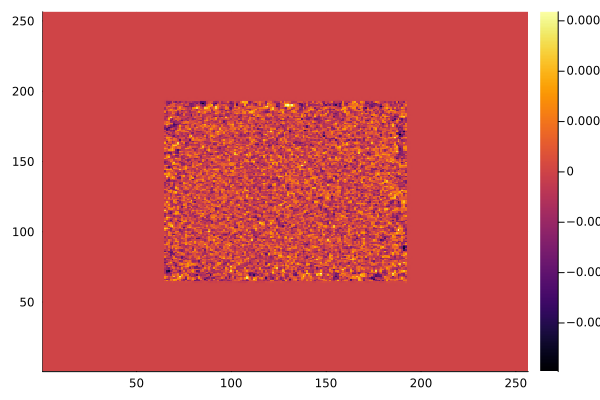

In [11]:
heatmap(mem[:,:,1,2])